# __Training and tuning the neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, February, 2024

## Main goals:

- Data processing for neural network application:
   - Elimination of extraneous features.
   - Normalization of the dataset.
   - ANN training, testing and validation dataset split.

- Training and evaluation of neural networks:
   - Custom neural network implementation.
   - Keras neural network implementation.
   
- Automation of hyperparameter setup for improved performance (criterion: accuracy).
   - Brute force for optimizing hyperparameters in the custom network.
   - Keras Tuning for optimizing Keras hyperparameters.
   
- Neural network performance assessment with and without 'less important features'.

- Compare custom ANN with Keras framework

## Coding

### Imported libraries

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

### Auxiliary functions

In [6]:
# Compute and display performance metrics 
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [7]:
# Compute and print ROC curve
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('AUC ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_real))]
    p_fpr, p_tpr, _ = roc_curve(y_real, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='random', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ANN', color='blue')
    
    # axis labels
    pyplot.xlabel('false positive rate')
    pyplot.ylabel('true positive rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [8]:
# split data into training, validation and testing sets
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [9]:
# Plot a bubble chart with two features according to NN classification
def bubble_chart(data, col_2_buble_size, col_x, col_y):
    fig, ax = plt.subplots(figsize=(15,13))
    sizes = data[col_2_buble_size]*10
    scatter = ax.scatter(data[col_x], data[col_y], 
           c=(data['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    ax.title.set_text("{}{}".format(len(data.index), ' landslides samples')) 

    plt.show()

In [10]:
# Plot a bubble chart with two features according to NN classification and the actual values
def  bubble_double_chart(data, col_2_buble_size, col_x, col_y, accuracy):
    sizes = data[col_2_buble_size]*10

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

    scatter = axes[0].scatter(data[col_x], data[col_y],
            c=(data['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    scatter = axes[1].scatter(data[col_x], data[col_y],
            c=(data['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    fig.tight_layout()
    text = 'predicted landslides ' + 'accuracy : {:.2f}%'.format(accuracy)
    axes[0].title.set_text('actual landslides')
    axes[1].title.set_text(text)

    plt.show()

In [11]:
def out_file_name(input_file_name):
    folder_bestANN = 'bestANN\\'
    
    if not os.path.exists(folder_bestANN):
      os.mkdir(folder_bestANN)
    
    out_f = os.path.splitext(input_file_name)[0]
    
    out_NN_custom = folder_bestANN + 'customNN_' + out_f + '.pkl'
    out_NN_keras  = folder_bestANN + 'kerasNN_' + out_f
    
    return out_NN_custom, out_NN_keras

### Select the dataset

- Switch one among the nine samples used in this study. The samples are configured according to the landslides' non-occurrence points' distance from the respective occurrence spot.

In [12]:
APP_PATH = os.getcwd()
#file = "guaruja_radius_50m_shuffled.csv"
#file = "guaruja_radius_100m_shuffled.csv"
#file = "guaruja_radius_150m_shuffled.csv"
#file = "guaruja_radius_200m_shuffled.csv"

#file = "guaruja_buffer_1km_shuffled.csv"
#file = "guaruja_buffer_2km_shuffled.csv"
#file = "guaruja_buffer_3km_shuffled.csv"
#file = "guaruja_buffer_4km_shuffled.csv"

file = "guaruja_random.csv"

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [13]:
dataset.shape

(200, 11)

In [14]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,100.50,375351.60,7350229.58,14.42,0.03,23.94,64.32,209.79,32.56,75.80,0.5
std,57.88,4313.00,4368.70,13.62,0.41,11.79,56.08,103.92,31.56,26.72,0.5
min,1.00,365857.79,7341789.72,0.09,-0.59,0.09,0.23,0.04,2.00,20.00,0.0
25%,50.75,372179.26,7346972.48,4.29,-0.01,18.08,14.33,121.04,2.00,90.00,0.0
50%,100.50,375219.03,7349677.08,6.13,-0.00,25.33,54.48,202.74,2.00,90.00,0.0
75%,150.25,379116.73,7354032.25,26.33,0.00,30.77,94.71,316.40,65.00,90.00,1.0
max,200.00,383738.84,7359892.24,69.73,4.30,69.73,226.06,359.51,65.00,90.00,1.0


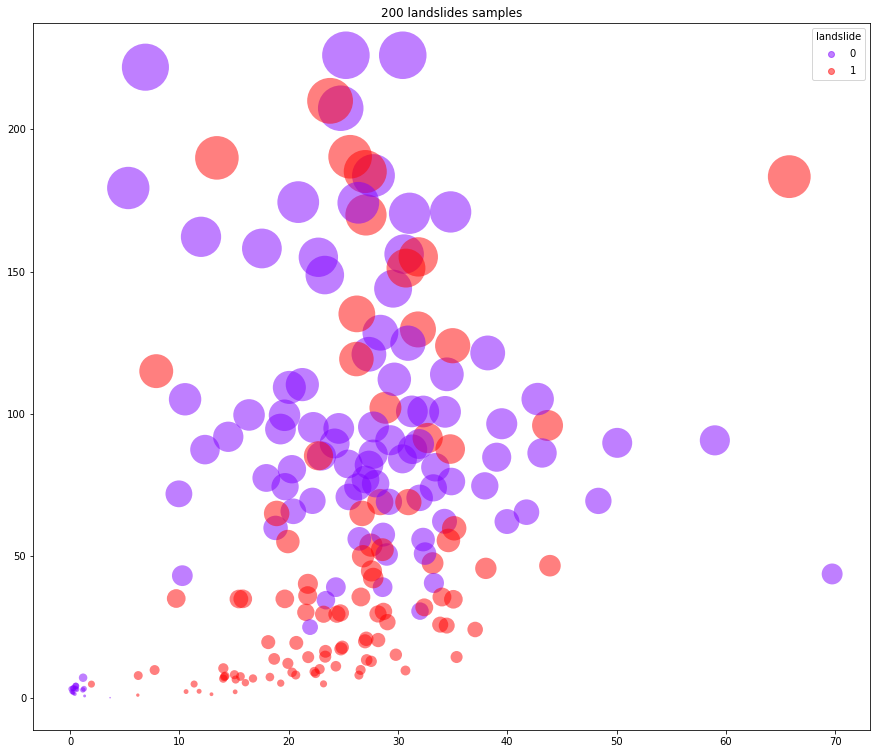

In [15]:
bubble_chart(dataset,"elevation","slope","elevation")

### Data Preparation
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

 - About most important features in best performed samples

  - Considering the random and 200m samples those with the best performance.
  - According to previous analyses we notice some features are less relevant than others.

     - In the scenario of a random sample, the pivotal features are identified as **twi**, **elevation**, and **land_use**. The overall accuracy, achieved with the optimal configuration using only these features, stands at approximately 98.50%, while utilizing all features yields a consistent 99% accuracy.

     - In instances where an event does not occur within a 200-meter radius of the sample occurrence, the most crucial features include **slope**, **twi**, **aspect**, and **curvature**. The overall accuracy, achieved with the best configuration using these features, is approximately 94.92%, compared to 93.91% when utilizing all features, a result that remains consistent.

After conducting numerous tests, it has been observed that the accuracy of the Artificial Neural Network (ANN) remains largely consistent, whether the most crucial features are included or not. Consequently, the decision has been made to retain all features in the model.

In [16]:
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]

#dataset = dataset.drop('slope',axis=1)
#dataset = dataset.drop('aspect',axis=1)

#dataset = dataset.drop('lithology',axis=1)
#dataset = dataset.drop('curvature',axis=1)

#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('land_use',axis=1)

#dataset.head(5)

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation(dataset)

In [18]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [19]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [20]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [21]:
X.shape

(200, 7)

In [22]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [23]:
y.shape

(200, 1)

In [24]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


__Compute the number of input and output features__

In [25]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- Custom implementation for classes and functions

In [26]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [27]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [28]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [29]:
# (batch_size) Implements the mini-batch that accelerates the training time, requires a mini-batch initialization method. 
#It is ideal for the batch size to be a multiple of the training dataset size, which is 128 here.
neurons = [7,8,12] 
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [30]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 0.70909005 + 0.00000000 = 0.70909005 loss_val = 0.70909005
epoch: 3000/40000 loss_train: 0.42993066 + 0.00000000 = 0.42993066 loss_val = 0.42993066
epoch: 6000/40000 loss_train: 0.27842310 + 0.00000000 = 0.27842310 loss_val = 0.27842310
epoch: 9000/40000 loss_train: 0.18410158 + 0.00000000 = 0.18410158 loss_val = 0.18410158
epoch: 12000/40000 loss_train: 0.12668929 + 0.00000000 = 0.12668929 loss_val = 0.12668929
epoch: 15000/40000 loss_train: 0.09664295 + 0.00000000 = 0.09664295 loss_val = 0.09664295
epoch: 18000/40000 loss_train: 0.07897725 + 0.00000000 = 0.07897725 loss_val = 0.07897725
epoch: 21000/40000 loss_train: 0.06778116 + 0.00000000 = 0.06778116 loss_val = 0.06778116
epoch: 24000/40000 loss_train: 0.06000367 + 0.00000000 = 0.06000367 loss_val = 0.06000367
epoch: 27000/40000 loss_train: 0.05426488 + 0.00000000 = 0.05426488 loss_val = 0.05426488
epoch: 30000/40000 loss_train: 0.04967011 + 0.00000000 = 0.04967011 loss_val = 0.04967011
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.24327786 + 0.00000000 = 0.24327786 loss_val = 0.24327786
epoch: 6000/40000 loss_train: 0.06788636 + 0.00000000 = 0.06788636 loss_val = 0.06788636
epoch: 9000/40000 loss_train: 0.03879809 + 0.00000000 = 0.03879809 loss_val = 0.03879809
epoch: 12000/40000 loss_train: 0.02863461 + 0.00000000 = 0.02863461 loss_val = 0.02863461
epoch: 15000/40000 loss_train: 0.02234534 + 0.00000000 = 0.02234534 loss_val = 0.02234534
epoch: 18000/40000 loss_train: 0.01805394 + 0.00000000 = 0.01805394 loss_val = 0.01805394
epoch: 21000/40000 loss_train: 0.01488943 + 0.00000000 = 0.01488943 loss_val = 0.01488943
epoch: 24000/40000 loss_train: 0.01248189 + 0.00000000 = 0.01248189 loss_val = 0.01248189
epoch: 27000/40000 loss_train: 0.01060669 + 0.00000000 = 0.01060669 loss_val = 0.01060669
epoch: 30000/40000 loss_train: 0.00905202 + 0.00000000 = 0.00905202 loss_val = 0.00905202
epoch: 33000/40000 loss_train: 0.00781406 + 0.00000000 = 0.00781406 loss_val = 0.00781406
epoch: 36000/

epoch: 9000/40000 loss_train: 0.02586572 + 0.00000000 = 0.02586572 loss_val = 0.02586572
epoch: 12000/40000 loss_train: 0.01728082 + 0.00000000 = 0.01728082 loss_val = 0.01728082
epoch: 15000/40000 loss_train: 0.01159421 + 0.00000000 = 0.01159421 loss_val = 0.01159421
epoch: 18000/40000 loss_train: 0.00818943 + 0.00000000 = 0.00818943 loss_val = 0.00818943
epoch: 21000/40000 loss_train: 0.00591931 + 0.00000000 = 0.00591931 loss_val = 0.00591931
epoch: 24000/40000 loss_train: 0.00447186 + 0.00000000 = 0.00447186 loss_val = 0.00447186
To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.69897846 + 0.00000000 = 0.69897846 loss_val = 0.69897846
epoch: 3000/40000 loss_train: 0.04547370 + 0.00000000 = 0.04547370 loss_val = 0.04547370
epoch: 6000/40000 loss_train: 0.02459750 + 0.00000000 = 0.02459750 loss_val = 0.02459750
epoch: 9000/40000 loss_train: 0.01681690 + 0.00000000 = 0.01681690 loss_val = 0.016816

epoch: 15000/40000 loss_train: 0.07851384 + 0.00000000 = 0.07851384 loss_val = 0.07851384
epoch: 18000/40000 loss_train: 0.06796953 + 0.00000000 = 0.06796953 loss_val = 0.06796953
epoch: 21000/40000 loss_train: 0.06047268 + 0.00000000 = 0.06047268 loss_val = 0.06047268
epoch: 24000/40000 loss_train: 0.05463024 + 0.00000000 = 0.05463024 loss_val = 0.05463024
epoch: 27000/40000 loss_train: 0.04990686 + 0.00000000 = 0.04990686 loss_val = 0.04990686
epoch: 30000/40000 loss_train: 0.04601199 + 0.00000000 = 0.04601199 loss_val = 0.04601199
epoch: 33000/40000 loss_train: 0.04271484 + 0.00000000 = 0.04271484 loss_val = 0.04271484
epoch: 36000/40000 loss_train: 0.03988430 + 0.00000000 = 0.03988430 loss_val = 0.03988430
epoch: 39000/40000 loss_train: 0.03741346 + 0.00000000 = 0.03741346 loss_val = 0.03741346
To 8 neurons, 1 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.84525668 + 0.00000000 = 0.84525668 loss_val = 0.8452

epoch: 33000/40000 loss_train: 0.01410979 + 0.00000000 = 0.01410979 loss_val = 0.01410979
epoch: 36000/40000 loss_train: 0.01110534 + 0.00000000 = 0.01110534 loss_val = 0.01110534
epoch: 39000/40000 loss_train: 0.00896782 + 0.00000000 = 0.00896782 loss_val = 0.00896782
To 8 neurons, 1 layer(s),  0.005 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.88125770 + 0.00000000 = 0.88125770 loss_val = 0.88125770
epoch: 3000/40000 loss_train: 0.13674986 + 0.00000000 = 0.13674986 loss_val = 0.13674986
epoch: 6000/40000 loss_train: 0.07149431 + 0.00000000 = 0.07149431 loss_val = 0.07149431
epoch: 9000/40000 loss_train: 0.05037968 + 0.00000000 = 0.05037968 loss_val = 0.05037968
epoch: 12000/40000 loss_train: 0.03867460 + 0.00000000 = 0.03867460 loss_val = 0.03867460
epoch: 15000/40000 loss_train: 0.03079036 + 0.00000000 = 0.03079036 loss_val = 0.03079036
epoch: 18000/40000 loss_train: 0.02496877 + 0.00000000 = 0.02496877 loss_val = 0.024968

epoch: 21000/40000 loss_train: 0.01877985 + 0.00000000 = 0.01877985 loss_val = 0.01877985
epoch: 24000/40000 loss_train: 0.01533093 + 0.00000000 = 0.01533093 loss_val = 0.01533093
epoch: 27000/40000 loss_train: 0.01270596 + 0.00000000 = 0.01270596 loss_val = 0.01270596
epoch: 30000/40000 loss_train: 0.01070180 + 0.00000000 = 0.01070180 loss_val = 0.01070180
epoch: 33000/40000 loss_train: 0.00915081 + 0.00000000 = 0.00915081 loss_val = 0.00915081
epoch: 36000/40000 loss_train: 0.00793537 + 0.00000000 = 0.00793537 loss_val = 0.00793537
epoch: 39000/40000 loss_train: 0.00696935 + 0.00000000 = 0.00696935 loss_val = 0.00696935
To 8 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.77907939 + 0.00000000 = 0.77907939 loss_val = 0.77907939
epoch: 3000/40000 loss_train: 0.10007007 + 0.00000000 = 0.10007007 loss_val = 0.10007007
epoch: 6000/40000 loss_train: 0.07441518 + 0.00000000 = 0.07441518 loss_val = 0.074415

epoch: 9000/40000 loss_train: 0.23845305 + 0.00000000 = 0.23845305 loss_val = 0.23845305
epoch: 12000/40000 loss_train: 0.16325373 + 0.00000000 = 0.16325373 loss_val = 0.16325373
epoch: 15000/40000 loss_train: 0.12809212 + 0.00000000 = 0.12809212 loss_val = 0.12809212
epoch: 18000/40000 loss_train: 0.10891073 + 0.00000000 = 0.10891073 loss_val = 0.10891073
epoch: 21000/40000 loss_train: 0.09754703 + 0.00000000 = 0.09754703 loss_val = 0.09754703
epoch: 24000/40000 loss_train: 0.08997677 + 0.00000000 = 0.08997677 loss_val = 0.08997677
epoch: 27000/40000 loss_train: 0.08440346 + 0.00000000 = 0.08440346 loss_val = 0.08440346
epoch: 30000/40000 loss_train: 0.07993187 + 0.00000000 = 0.07993187 loss_val = 0.07993187
epoch: 33000/40000 loss_train: 0.07614425 + 0.00000000 = 0.07614425 loss_val = 0.07614425
epoch: 36000/40000 loss_train: 0.07288650 + 0.00000000 = 0.07288650 loss_val = 0.07288650
epoch: 39000/40000 loss_train: 0.06992655 + 0.00000000 = 0.06992655 loss_val = 0.06992655
To 12 neuro

To 12 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.84034373 + 0.00000000 = 0.84034373 loss_val = 0.84034373
epoch: 3000/40000 loss_train: 0.06411750 + 0.00000000 = 0.06411750 loss_val = 0.06411750
epoch: 6000/40000 loss_train: 0.03999201 + 0.00000000 = 0.03999201 loss_val = 0.03999201
epoch: 9000/40000 loss_train: 0.02901806 + 0.00000000 = 0.02901806 loss_val = 0.02901806
epoch: 12000/40000 loss_train: 0.02157562 + 0.00000000 = 0.02157562 loss_val = 0.02157562
epoch: 15000/40000 loss_train: 0.01621380 + 0.00000000 = 0.01621380 loss_val = 0.01621380
epoch: 18000/40000 loss_train: 0.01218788 + 0.00000000 = 0.01218788 loss_val = 0.01218788
epoch: 21000/40000 loss_train: 0.00910094 + 0.00000000 = 0.00910094 loss_val = 0.00910094
To 12 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.73542502 + 0.00000000 = 0.73542502 los

epoch: 18000/40000 loss_train: 0.10881508 + 0.00000000 = 0.10881508 loss_val = 0.10881508
epoch: 21000/40000 loss_train: 0.08772738 + 0.00000000 = 0.08772738 loss_val = 0.08772738
epoch: 24000/40000 loss_train: 0.07838226 + 0.00000000 = 0.07838226 loss_val = 0.07838226
epoch: 27000/40000 loss_train: 0.07218188 + 0.00000000 = 0.07218188 loss_val = 0.07218188
epoch: 30000/40000 loss_train: 0.06795801 + 0.00000000 = 0.06795801 loss_val = 0.06795801
epoch: 33000/40000 loss_train: 0.06395849 + 0.00000000 = 0.06395849 loss_val = 0.06395849
epoch: 36000/40000 loss_train: 0.06045103 + 0.00000000 = 0.06045103 loss_val = 0.06045103
epoch: 39000/40000 loss_train: 0.05901490 + 0.00000000 = 0.05901490 loss_val = 0.05901490
To 7 neurons, 2 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 95.24% 
epoch:    0/40000 loss_train: 0.74607372 + 0.00000000 = 0.74607372 loss_val = 0.74607372
epoch: 3000/40000 loss_train: 0.50855810 + 0.00000000 = 0.50855810 loss_val = 0.50855

epoch: 6000/40000 loss_train: 0.07062367 + 0.00000000 = 0.07062367 loss_val = 0.07062367
To 7 neurons, 2 layer(s),  0.005 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 1.03639270 + 0.00000000 = 1.03639270 loss_val = 1.03639270
epoch: 3000/40000 loss_train: 0.08303941 + 0.00000000 = 0.08303941 loss_val = 0.08303941
epoch: 6000/40000 loss_train: 0.04257914 + 0.00000000 = 0.04257914 loss_val = 0.04257914
epoch: 9000/40000 loss_train: 0.02793259 + 0.00000000 = 0.02793259 loss_val = 0.02793259
epoch: 12000/40000 loss_train: 0.01992886 + 0.00000000 = 0.01992886 loss_val = 0.01992886
epoch: 15000/40000 loss_train: 0.01410904 + 0.00000000 = 0.01410904 loss_val = 0.01410904
epoch: 18000/40000 loss_train: 0.00996122 + 0.00000000 = 0.00996122 loss_val = 0.00996122
epoch: 21000/40000 loss_train: 0.00712997 + 0.00000000 = 0.00712997 loss_val = 0.00712997
To 7 neurons, 2 layer(s),  0.005 learning rate, 8 batch size, 0 dropout rate, we have:

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


epoch: 3000/40000 loss_train: 0.55237709 + 0.00000000 = 0.55237709 loss_val = 0.55237709
epoch: 6000/40000 loss_train: 0.19096351 + 0.00000000 = 0.19096351 loss_val = 0.19096351
epoch: 9000/40000 loss_train: 0.09620697 + 0.00000000 = 0.09620697 loss_val = 0.09620697
epoch: 12000/40000 loss_train: 0.05967384 + 0.00000000 = 0.05967384 loss_val = 0.05967384
epoch: 15000/40000 loss_train: 0.04273704 + 0.00000000 = 0.04273704 loss_val = 0.04273704
epoch: 18000/40000 loss_train: 0.03293024 + 0.00000000 = 0.03293024 loss_val = 0.03293024
To 7 neurons, 2 layer(s),  0.005 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.96861722 + 0.00000000 = 0.96861722 loss_val = 0.96861722
epoch: 3000/40000 loss_train: 0.06571688 + 0.00000000 = 0.06571688 loss_val = 0.06571688
epoch: 6000/40000 loss_train: 0.01354480 + 0.00000000 = 0.01354480 loss_val = 0.01354480
epoch: 9000/40000 loss_train: 0.00619793 + 0.00000000 = 0.00619793 loss_val = 0.00619793

epoch: 12000/40000 loss_train: 0.15995222 + 0.00000000 = 0.15995222 loss_val = 0.15995222
epoch: 15000/40000 loss_train: 0.11981392 + 0.00000000 = 0.11981392 loss_val = 0.11981392
epoch: 18000/40000 loss_train: 0.10010929 + 0.00000000 = 0.10010929 loss_val = 0.10010929
epoch: 21000/40000 loss_train: 0.08814490 + 0.00000000 = 0.08814490 loss_val = 0.08814490
epoch: 24000/40000 loss_train: 0.07968967 + 0.00000000 = 0.07968967 loss_val = 0.07968967
epoch: 27000/40000 loss_train: 0.07296810 + 0.00000000 = 0.07296810 loss_val = 0.07296810
epoch: 30000/40000 loss_train: 0.06752063 + 0.00000000 = 0.06752063 loss_val = 0.06752063
epoch: 33000/40000 loss_train: 0.06285507 + 0.00000000 = 0.06285507 loss_val = 0.06285507
epoch: 36000/40000 loss_train: 0.05875881 + 0.00000000 = 0.05875881 loss_val = 0.05875881
epoch: 39000/40000 loss_train: 0.05511017 + 0.00000000 = 0.05511017 loss_val = 0.05511017
To 8 neurons, 2 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 97

epoch: 3000/40000 loss_train: 0.10620360 + 0.00000000 = 0.10620360 loss_val = 0.10620360
To 8 neurons, 2 layer(s),  0.005 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 95.24% 
epoch:    0/40000 loss_train: 0.69852697 + 0.00000000 = 0.69852697 loss_val = 0.69852697
epoch: 3000/40000 loss_train: 0.11627166 + 0.00000000 = 0.11627166 loss_val = 0.11627166
epoch: 6000/40000 loss_train: 0.06743350 + 0.00000000 = 0.06743350 loss_val = 0.06743350
epoch: 9000/40000 loss_train: 0.05254142 + 0.00000000 = 0.05254142 loss_val = 0.05254142
epoch: 12000/40000 loss_train: 0.04470531 + 0.00000000 = 0.04470531 loss_val = 0.04470531
epoch: 15000/40000 loss_train: 0.03542470 + 0.00000000 = 0.03542470 loss_val = 0.03542470
epoch: 18000/40000 loss_train: 0.02598264 + 0.00000000 = 0.02598264 loss_val = 0.02598264
epoch: 21000/40000 loss_train: 0.01735806 + 0.00000000 = 0.01735806 loss_val = 0.01735806
epoch: 24000/40000 loss_train: 0.00895481 + 0.00000000 = 0.00895481 loss_val = 0.008954

To 12 neurons, 2 layer(s),  0.001 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.72849766 + 0.00000000 = 0.72849766 loss_val = 0.72849766
epoch: 3000/40000 loss_train: 0.63545271 + 0.00000000 = 0.63545271 loss_val = 0.63545271
epoch: 6000/40000 loss_train: 0.47881638 + 0.00000000 = 0.47881638 loss_val = 0.47881638
epoch: 9000/40000 loss_train: 0.31445189 + 0.00000000 = 0.31445189 loss_val = 0.31445189
epoch: 12000/40000 loss_train: 0.19300109 + 0.00000000 = 0.19300109 loss_val = 0.19300109
epoch: 15000/40000 loss_train: 0.13122669 + 0.00000000 = 0.13122669 loss_val = 0.13122669
epoch: 18000/40000 loss_train: 0.10037489 + 0.00000000 = 0.10037489 loss_val = 0.10037489
epoch: 21000/40000 loss_train: 0.07969384 + 0.00000000 = 0.07969384 loss_val = 0.07969384
To 12 neurons, 2 layer(s),  0.001 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.78531325 + 0.00000000 = 0.78531325 l

epoch: 27000/40000 loss_train: 0.00232104 + 0.00000000 = 0.00232104 loss_val = 0.00232104
epoch: 30000/40000 loss_train: 0.00193012 + 0.00000000 = 0.00193012 loss_val = 0.00193012
epoch: 33000/40000 loss_train: 0.00163544 + 0.00000000 = 0.00163544 loss_val = 0.00163544
epoch: 36000/40000 loss_train: 0.00140746 + 0.00000000 = 0.00140746 loss_val = 0.00140746
epoch: 39000/40000 loss_train: 0.00122724 + 0.00000000 = 0.00122724 loss_val = 0.00122724
To 12 neurons, 2 layer(s),  0.005 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.72344615 + 0.00000000 = 0.72344615 loss_val = 0.72344615
epoch: 3000/40000 loss_train: 0.10010802 + 0.00000000 = 0.10010802 loss_val = 0.10010802
epoch: 6000/40000 loss_train: 0.04353167 + 0.00000000 = 0.04353167 loss_val = 0.04353167
To 12 neurons, 2 layer(s),  0.005 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.83241036 + 0.00000000 = 0.83241036

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.75670604 + 0.00000000 = 0.75670604 loss_val = 0.75670604
epoch: 3000/40000 loss_train: 0.06309913 + 0.00000000 = 0.06309913 loss_val = 0.06309913
To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 1.20832771 + 0.00000000 = 1.20832771 loss_val = 1.20832771
epoch: 3000/40000 loss_train: 0.06564494 + 0.00000000 = 0.06564494 loss_val = 0.06564494
epoch: 6000/40000 loss_train: 0.04173328 + 0.00000000 = 0.04173328 loss_val = 0.04173328
epoch: 9000/40000 loss_train: 0.02267446 + 0.00000000 = 0.02267446 loss_val = 0.02267446
epoch: 12000/40000 loss_train: 0.01063548 + 0.00000000 = 0.01063548 loss_val = 0.01063548
epoch: 15000/40000 loss_train: 0.00465891 + 0.00000000 = 0.00465891 loss_val = 0.00465891
epoch: 18000/40000 loss_train: 0.00269291 + 0.00000000 = 0.00269291 los

epoch: 12000/40000 loss_train: 0.26892990 + 0.00000000 = 0.26892990 loss_val = 0.26892990
epoch: 15000/40000 loss_train: 0.24578828 + 0.00000000 = 0.24578828 loss_val = 0.24578828
epoch: 18000/40000 loss_train: 0.23469651 + 0.00000000 = 0.23469651 loss_val = 0.23469651
To 7 neurons, 3 layer(s),  0.001 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 88.10% 
epoch:    0/40000 loss_train: 0.71374695 + 0.00000000 = 0.71374695 loss_val = 0.71374695
epoch: 3000/40000 loss_train: 0.09062499 + 0.00000000 = 0.09062499 loss_val = 0.09062499
epoch: 6000/40000 loss_train: 0.06950644 + 0.00000000 = 0.06950644 loss_val = 0.06950644
epoch: 9000/40000 loss_train: 0.05712445 + 0.00000000 = 0.05712445 loss_val = 0.05712445
epoch: 12000/40000 loss_train: 0.04173186 + 0.00000000 = 0.04173186 loss_val = 0.04173186
epoch: 15000/40000 loss_train: 0.02543731 + 0.00000000 = 0.02543731 loss_val = 0.02543731
epoch: 18000/40000 loss_train: 0.01334604 + 0.00000000 = 0.01334604 loss_val = 0.01334

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 3 layer(s),  0.005 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.83852509 + 0.00000000 = 0.83852509 loss_val = 0.83852509
epoch: 3000/40000 loss_train: 0.27609525 + 0.00000000 = 0.27609525 loss_val = 0.27609525
epoch: 6000/40000 loss_train: 0.18081679 + 0.00000000 = 0.18081679 loss_val = 0.18081679
epoch: 9000/40000 loss_train: 0.04308723 + 0.00000000 = 0.04308723 loss_val = 0.04308723
To 7 neurons, 3 layer(s),  0.005 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.73040074 + 0.00000000 = 0.73040074 loss_val = 0.73040074
epoch: 3000/40000 loss_train: 0.20685359 + 0.00000000 = 0.20685359 loss_val = 0.20685359
epoch: 6000/40000 loss_train: 0.11086138 + 0.00000000 = 0.11086138 loss_val = 0.11086138
epoch: 9000/40000 loss_train: 0.01852675 + 0.00000000 = 0.01852675 loss_val = 0.01852675
epoch: 12000/40000 loss_train: 0.00709377 + 0.00000000 = 0.00709377 loss_

epoch: 30000/40000 loss_train: 0.04708700 + 0.00000000 = 0.04708700 loss_val = 0.04708700
epoch: 33000/40000 loss_train: 0.04116714 + 0.00000000 = 0.04116714 loss_val = 0.04116714
epoch: 36000/40000 loss_train: 0.03499414 + 0.00000000 = 0.03499414 loss_val = 0.03499414
epoch: 39000/40000 loss_train: 0.03010289 + 0.00000000 = 0.03010289 loss_val = 0.03010289
To 8 neurons, 3 layer(s),  0.001 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 95.24% 
epoch:    0/40000 loss_train: 0.93815074 + 0.00000000 = 0.93815074 loss_val = 0.93815074
epoch: 3000/40000 loss_train: 0.68807486 + 0.00000000 = 0.68807486 loss_val = 0.68807486
epoch: 6000/40000 loss_train: 0.67348263 + 0.00000000 = 0.67348263 loss_val = 0.67348263
epoch: 9000/40000 loss_train: 0.65924795 + 0.00000000 = 0.65924795 loss_val = 0.65924795
epoch: 12000/40000 loss_train: 0.63642445 + 0.00000000 = 0.63642445 loss_val = 0.63642445
epoch: 15000/40000 loss_train: 0.57677228 + 0.00000000 = 0.57677228 loss_val = 0.5767722

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.74783304 + 0.00000000 = 0.74783304 loss_val = 0.74783304
epoch: 3000/40000 loss_train: 0.26869202 + 0.00000000 = 0.26869202 loss_val = 0.26869202
epoch: 6000/40000 loss_train: 0.21039158 + 0.00000000 = 0.21039158 loss_val = 0.21039158
epoch: 9000/40000 loss_train: 0.20085098 + 0.00000000 = 0.20085098 loss_val = 0.20085098
To 8 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 88.10% 
epoch:    0/40000 loss_train: 0.66543312 + 0.00000000 = 0.66543312 loss_val = 0.66543312
epoch: 3000/40000 loss_train: 0.06842099 + 0.00000000 = 0.06842099 loss_val = 0.06842099
epoch: 6000/40000 loss_train: 0.02691863 + 0.00000000 = 0.02691863 loss_val = 0.02691863
epoch: 9000/40000 loss_train: 0.01404110 + 0.00000000 = 0.01404110 loss_val = 0.01404110
epoch: 12000/40000 loss_train: 0.00757109 + 0.00000000 = 0.00757109 loss_v

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.69291888 + 0.00000000 = 0.69291888 loss_val = 0.69291888
To 8 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 85.71% 
epoch:    0/40000 loss_train: 0.78255060 + 0.00000000 = 0.78255060 loss_val = 0.78255060
epoch: 3000/40000 loss_train: 0.21066212 + 0.00000000 = 0.21066212 loss_val = 0.21066212
epoch: 6000/40000 loss_train: 0.20030792 + 0.00000000 = 0.20030792 loss_val = 0.20030792
epoch: 9000/40000 loss_train: 0.19795148 + 0.00000000 = 0.19795148 loss_val = 0.19795148
epoch: 12000/40000 loss_train: 0.19734332 + 0.00000000 = 0.19734332 loss_val = 0.19734332
epoch: 15000/40000 loss_train: 0.19714604 + 0.00000000 = 0.19714604 loss_val = 0.19714604
epoch: 18000/40000 loss_train: 0.19704570 + 0.00000000 = 0.19704570 loss_val = 0.19704570
To 8 neurons, 3 layer(s),  0.01 learning rate, 4 batch size, 0 dropout ra

epoch: 18000/40000 loss_train: 0.06280360 + 0.00000000 = 0.06280360 loss_val = 0.06280360
epoch: 21000/40000 loss_train: 0.05661394 + 0.00000000 = 0.05661394 loss_val = 0.05661394
epoch: 24000/40000 loss_train: 0.05201964 + 0.00000000 = 0.05201964 loss_val = 0.05201964
epoch: 27000/40000 loss_train: 0.04819567 + 0.00000000 = 0.04819567 loss_val = 0.04819567
epoch: 30000/40000 loss_train: 0.04471311 + 0.00000000 = 0.04471311 loss_val = 0.04471311
epoch: 33000/40000 loss_train: 0.04147757 + 0.00000000 = 0.04147757 loss_val = 0.04147757
epoch: 36000/40000 loss_train: 0.03818134 + 0.00000000 = 0.03818134 loss_val = 0.03818134
epoch: 39000/40000 loss_train: 0.03484164 + 0.00000000 = 0.03484164 loss_val = 0.03484164
To 12 neurons, 3 layer(s),  0.001 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.73195548 + 0.00000000 = 0.73195548 loss_val = 0.73195548
epoch: 3000/40000 loss_train: 0.57718346 + 0.00000000 = 0.57718346 loss_val = 0.5771

epoch: 3000/40000 loss_train: 0.01861827 + 0.00000000 = 0.01861827 loss_val = 0.01861827
To 12 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.85032947 + 0.00000000 = 0.85032947 loss_val = 0.85032947
epoch: 3000/40000 loss_train: 0.01753153 + 0.00000000 = 0.01753153 loss_val = 0.01753153
epoch: 6000/40000 loss_train: 0.00424293 + 0.00000000 = 0.00424293 loss_val = 0.00424293
epoch: 9000/40000 loss_train: 0.00188504 + 0.00000000 = 0.00188504 loss_val = 0.00188504
epoch: 12000/40000 loss_train: 0.00105273 + 0.00000000 = 0.00105273 loss_val = 0.00105273
epoch: 15000/40000 loss_train: 0.00069638 + 0.00000000 = 0.00069638 loss_val = 0.00069638
epoch: 18000/40000 loss_train: 0.00050581 + 0.00000000 = 0.00050581 loss_val = 0.00050581
epoch: 21000/40000 loss_train: 0.00038964 + 0.00000000 = 0.00038964 loss_val = 0.00038964
epoch: 24000/40000 loss_train: 0.00031255 + 0.00000000 = 0.00031255 loss_val = 0.000312

In [31]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append(hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layer(s),{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

100.00% was the best accuracy, having 1 layer(s),7 neurons, 0.001 of learning rate and 0 of batch size as hyperparameters!


In [32]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

100.00% was the best accuracy, with ANN <Rede_Neural.NeuralNetwork object at 0x00000203E6ACD280> 


In [33]:
print('{} was the number of anns trained '.format(len(lst_ANN)))
lst_hyperP = []
lst_ANN = []

162 was the number of anns trained 


#### Assessment

In [34]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% as the best\033[1m accurancy\033[0m, {:.2f} average acc {} ANN!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

98.33% accu_test - 100.00% as the best accurancy, 99.17 average acc <Rede_Neural.NeuralNetwork object at 0x00000203E6ACD280> ANN!


In [35]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers,{} neurons, {} of learning rate, {} batch size and {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% as the best accurancy, configured with 1 layers,7 neurons, 0.001 of learning rate, 0 batch size and 0 dropout rate!


In [36]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [37]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

98.33%, test sample accurancy !


**Second approach** - Configure another ANN with the parameters obtained from the brute-force optimization.

In [38]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [39]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers, {} of learning rate, {} batch size and {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

100.00% as the best accurancy, configured with 1 layers, 0.001 of learning rate, 0 batch size and 0 dropout rate!


In [40]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

98.33%, test sample accurancy !


#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [41]:
NN_custom, NN_keras = out_file_name(file)

In [42]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved in \033[1m{}\033[0m!'.format(accu,NN_custom))
    bestNN.save(NN_custom)
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

98.33%, excellent accuracy for test sample, ANN saved in bestANN\customNN_guaruja_random.pkl!


#### Overall results

In [43]:
y_pred = bestNN.predict(X_train)
print('\033[1mTraining sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_train, y_pred > 0.5)))
NetworkPerformance(y_train, y_pred)

Training sample accuracy: 100.00%
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[46  0]
 [ 0 52]]


In [44]:
y_pred = bestNN.predict(X_val)
print('\033[1mValidation sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_val, y_pred > 0.5)))
NetworkPerformance(y_val, y_pred)

Validation sample accuracy: 100.00%
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]


In [45]:
y_pred = bestNN.predict(X_test)
print('\033[1mTest sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_test, y_pred > 0.5)))
NetworkPerformance(y_test, y_pred)

Test sample accuracy: 98.33%
Accuracy: 0.983333
Precision: 1.000000
Recall: 0.965517
F1 score: 0.982456
Cohens kappa: 0.966592
ROC AUC: 0.988877
[[31  0]
 [ 1 28]]


In [46]:
y_pred = bestNN.predict(X)
print('\033[1mOverall sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y, y_pred > 0.5)))
NetworkPerformance(y, y_pred)

Overall sample accuracy: 99.50%
Accuracy: 0.995000
Precision: 1.000000
Recall: 0.989899
F1 score: 0.994924
Cohens kappa: 0.989998
ROC AUC: 0.997200
[[101   0]
 [  1  98]]


AUC ROC=0.9972


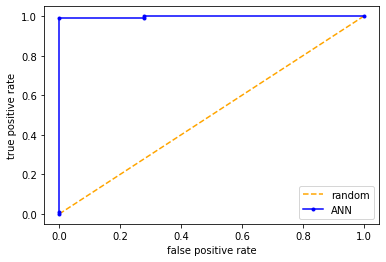

In [47]:
printAUROC(y,y_pred)

In [48]:
cf_matrix = confusion_matrix(y,(y_pred > 0.5))

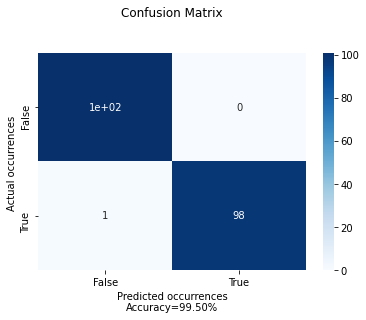

In [49]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAccuracy={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [50]:
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred

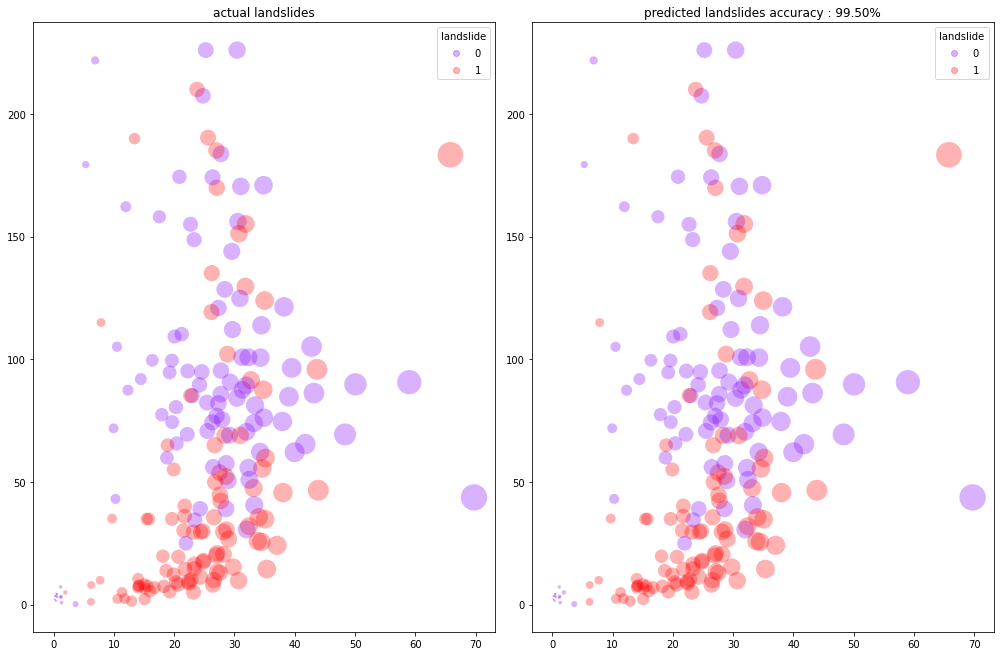

In [51]:
bubble_double_chart(output_dataset,"slope","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

#### RepeatedStratifiedKfold Assessment 

In [52]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


In [53]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Number of Splits_stratified of X: ',rskf.get_n_splits(X, y),'\n')

# Print_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Number of Splits_stratified of X:  10 

(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)


In [54]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [100.0, 100.0, 97.5, 100.0, 100.0, 100.0, 97.5, 100.0, 100.0, 100.0]

Maximum accuracy: 100.0 %

Minimum accuracy: 97.5 %

Avarage accuracy: 99.5 %

Standard deviation: 1.0540925533894598


In [55]:
dataset

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0
...,...,...,...,...,...,...,...,...
195,65.807915,335.578705,183.386307,90,65,3.111852,0.009217,1
196,34.884327,335.742798,76.214539,90,2,34.884327,-0.003104,0
197,16.367725,167.967239,99.617256,90,2,16.367725,0.009234,0
198,30.434063,155.315613,226.055237,90,65,30.434063,0.000543,0


ROC AUC=0.997


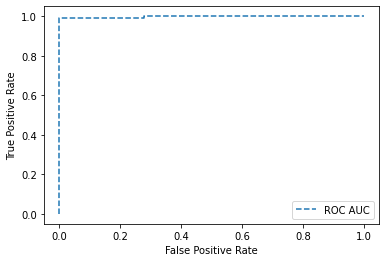

In [56]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [57]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred

Acurácia: 99.50%


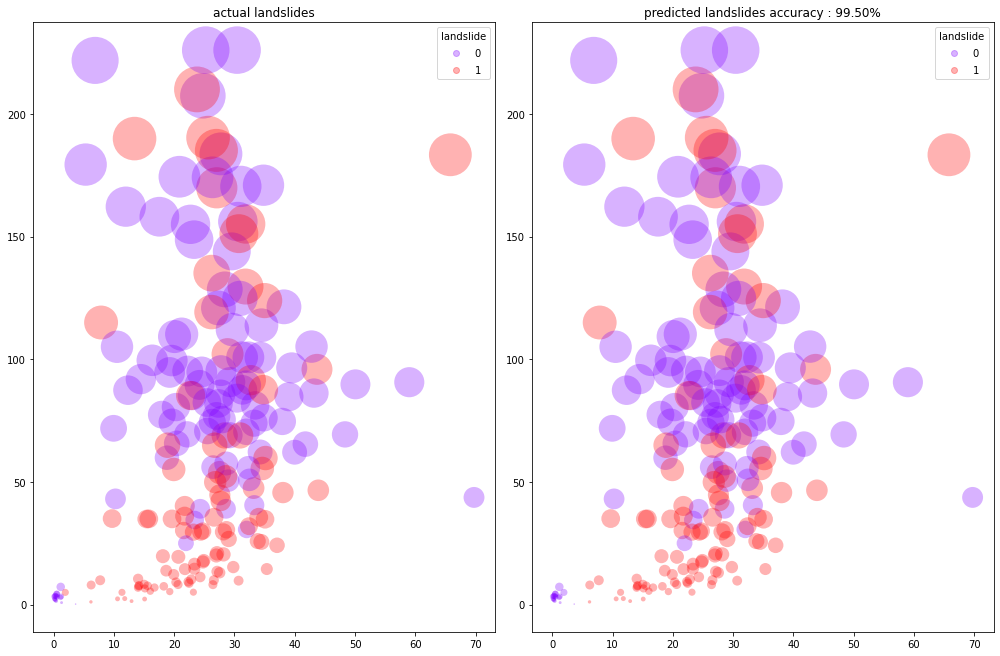

In [58]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

In [59]:
end = datetime.datetime.now()
print(end-start)
#quit()

0:42:37.834015


### Keras Framework
__Clasification problem, see best practices:__
- Hyperparameters tuning
- Baseline to custom implementation 

In [60]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [61]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [62]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
20/20 [==============================] - 1s 822us/step - loss: 0.7119 - accuracy: 0.4490
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.5714
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5510
Epoch 4/500
20/20 [==============================] - 0s 820us/step - loss: 0.6259 - accuracy: 0.7449
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6741 - accuracy: 0.6020
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6354 - accuracy: 0.6224
Epoch 7/500
20/20 [==============================] - 0s 825us/step - loss: 0.6315 - accuracy: 0.6531
Epoch 8/500
20/20 [==============================] - 0s 822us/step - loss: 0.6103 - accuracy: 0.7143
Epoch 9/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6115 - accuracy: 0.7041
Epoch 10/500
20/20 [==============================] - 0s 822us/step - loss: 0.6091 - accuracy: 0.7551

20/20 [==============================] - 0s 823us/step - loss: 0.1905 - accuracy: 0.8980
Epoch 83/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1785 - accuracy: 0.9490
Epoch 84/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1480 - accuracy: 0.9694
Epoch 85/500
20/20 [==============================] - 0s 822us/step - loss: 0.1665 - accuracy: 0.9388
Epoch 86/500
20/20 [==============================] - 0s 824us/step - loss: 0.1527 - accuracy: 0.9490
Epoch 87/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1944 - accuracy: 0.9184
Epoch 88/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.9490
Epoch 89/500
20/20 [==============================] - 0s 822us/step - loss: 0.1453 - accuracy: 0.9592
Epoch 90/500
20/20 [==============================] - 0s 821us/step - loss: 0.1426 - accuracy: 0.9490
Epoch 91/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1390 - accuracy: 0.9694
Epo

20/20 [==============================] - 0s 822us/step - loss: 0.1012 - accuracy: 0.9694
Epoch 163/500
20/20 [==============================] - 0s 820us/step - loss: 0.0793 - accuracy: 0.9898
Epoch 164/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0870 - accuracy: 0.9898
Epoch 165/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9592
Epoch 166/500
20/20 [==============================] - 0s 822us/step - loss: 0.0828 - accuracy: 0.9592
Epoch 167/500
20/20 [==============================] - 0s 822us/step - loss: 0.0771 - accuracy: 0.9796
Epoch 168/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0828 - accuracy: 0.9898
Epoch 169/500
20/20 [==============================] - 0s 823us/step - loss: 0.0968 - accuracy: 0.9898
Epoch 170/500
20/20 [==============================] - 0s 824us/step - loss: 0.1001 - accuracy: 0.9490
Epoch 171/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0886 - accuracy:

20/20 [==============================] - 0s 822us/step - loss: 0.0538 - accuracy: 0.9796
Epoch 243/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0573 - accuracy: 0.9898
Epoch 244/500
20/20 [==============================] - 0s 823us/step - loss: 0.0696 - accuracy: 0.9796
Epoch 245/500
20/20 [==============================] - 0s 820us/step - loss: 0.0700 - accuracy: 0.9796
Epoch 246/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0733 - accuracy: 0.9796
Epoch 247/500
20/20 [==============================] - 0s 824us/step - loss: 0.0740 - accuracy: 0.9694
Epoch 248/500
20/20 [==============================] - 0s 824us/step - loss: 0.0581 - accuracy: 0.9898
Epoch 249/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0503 - accuracy: 0.9796
Epoch 250/500
20/20 [==============================] - 0s 824us/step - loss: 0.1055 - accuracy: 0.9592
Epoch 251/500
20/20 [==============================] - 0s 822us/step - loss: 0.0467 - accurac

20/20 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9796
Epoch 323/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0564 - accuracy: 0.9694
Epoch 324/500
20/20 [==============================] - 0s 823us/step - loss: 0.0350 - accuracy: 0.9898
Epoch 325/500
20/20 [==============================] - 0s 824us/step - loss: 0.0616 - accuracy: 0.9592
Epoch 326/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0656 - accuracy: 0.9796
Epoch 327/500
20/20 [==============================] - 0s 822us/step - loss: 0.0535 - accuracy: 0.9796
Epoch 328/500
20/20 [==============================] - 0s 822us/step - loss: 0.0594 - accuracy: 0.9796
Epoch 329/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.9898
Epoch 330/500
20/20 [==============================] - 0s 822us/step - loss: 0.0488 - accuracy: 0.9796
Epoch 331/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0608 - accuracy: 0

20/20 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9694
Epoch 403/500
20/20 [==============================] - 0s 822us/step - loss: 0.0407 - accuracy: 0.9898
Epoch 404/500
20/20 [==============================] - 0s 822us/step - loss: 0.0414 - accuracy: 0.9898
Epoch 405/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0664 - accuracy: 0.9694
Epoch 406/500
20/20 [==============================] - 0s 822us/step - loss: 0.0379 - accuracy: 0.9898
Epoch 407/500
20/20 [==============================] - 0s 822us/step - loss: 0.0474 - accuracy: 0.9796
Epoch 408/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0474 - accuracy: 0.9796
Epoch 409/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 1.0000
Epoch 410/500
20/20 [==============================] - 0s 824us/step - loss: 0.0344 - accuracy: 0.9898
Epoch 411/500
20/20 [==============================] - 0s 824us/step - loss: 0.0479 - accuracy:

20/20 [==============================] - 0s 2ms/step - loss: 0.0344 - accuracy: 0.9796
Epoch 483/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9796
Epoch 484/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9898
Epoch 485/500
20/20 [==============================] - 0s 824us/step - loss: 0.0364 - accuracy: 0.9898
Epoch 486/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0491 - accuracy: 0.9796
Epoch 487/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0489 - accuracy: 0.9796
Epoch 488/500
20/20 [==============================] - 0s 823us/step - loss: 0.0228 - accuracy: 1.0000
Epoch 489/500
20/20 [==============================] - 0s 822us/step - loss: 0.0377 - accuracy: 0.9898
Epoch 490/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0271 - accuracy: 0.9898
Epoch 491/500
20/20 [==============================] - 0s 824us/step - loss: 0.0381 - accuracy: 1.0

In [63]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 149


In [64]:
# keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 2ms/step - loss: 0.1283 - accuracy: 0.9667
Accuracy: 96.67


In [65]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/149
4/4 [==============================] - 0s 0s/step - loss: 0.0202 - accuracy: 1.0000
Epoch 2/149
4/4 [==============================] - 0s 0s/step - loss: 0.0242 - accuracy: 1.0000
Epoch 3/149
4/4 [==============================] - 0s 5ms/step - loss: 0.0273 - accuracy: 1.0000
Epoch 4/149
4/4 [==============================] - 0s 0s/step - loss: 0.0379 - accuracy: 0.9898
Epoch 5/149
4/4 [==============================] - 0s 5ms/step - loss: 0.0340 - accuracy: 0.9898
Epoch 6/149
4/4 [==============================] - 0s 0s/step - loss: 0.0390 - accuracy: 0.9898
Epoch 7/149
4/4 [==============================] - 0s 5ms/step - loss: 0.0297 - accuracy: 1.0000
Epoch 8/149
4/4 [==============================] - 0s 0s/step - loss: 0.0411 - accuracy: 0.9796
Epoch 9/149
4/4 [==============================] - 0s 0s/step - loss: 0.0361 - accuracy: 0.9796
Epoch 10/149
4/4 [==============================] - 0s 5ms/step - loss: 0.0201 - accuracy: 1.0000
Epoch 11/149
4/4 [=================

4/4 [==============================] - 0s 5ms/step - loss: 0.0213 - accuracy: 1.0000
Epoch 86/149
4/4 [==============================] - 0s 0s/step - loss: 0.0180 - accuracy: 1.0000
Epoch 87/149
4/4 [==============================] - 0s 0s/step - loss: 0.0290 - accuracy: 0.9898
Epoch 88/149
4/4 [==============================] - 0s 0s/step - loss: 0.0412 - accuracy: 0.9796
Epoch 89/149
4/4 [==============================] - 0s 5ms/step - loss: 0.0234 - accuracy: 1.0000
Epoch 90/149
4/4 [==============================] - 0s 5ms/step - loss: 0.0210 - accuracy: 1.0000
Epoch 91/149
4/4 [==============================] - 0s 0s/step - loss: 0.0309 - accuracy: 0.9898
Epoch 92/149
4/4 [==============================] - 0s 0s/step - loss: 0.0283 - accuracy: 1.0000
Epoch 93/149
4/4 [==============================] - 0s 5ms/step - loss: 0.0429 - accuracy: 0.9898
Epoch 94/149
4/4 [==============================] - 0s 0s/step - loss: 0.0351 - accuracy: 0.9898
Epoch 95/149
4/4 [=====================

#### Assessment

In [66]:
# Keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 0s/step - loss: 0.1285 - accuracy: 0.9667
Accuracy: 96.67


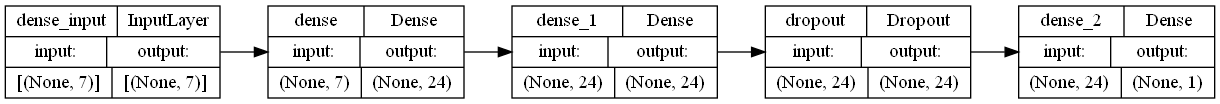

In [67]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [68]:
accu = 100*accuracy

In [69]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved in \033[1m{}\033[0m!'.format(accu,NN_keras))
    hypermodel.save(NN_keras) 
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

96.67%, excellent accuracy for test sample, ANN saved in bestANN\kerasNN_guaruja_random!
INFO:tensorflow:Assets written to: bestANN\kerasNN_guaruja_random\assets


#### RepeatedStratifiedKFold Assessment

In [70]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Splits numbers of X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Splits numbers of X:  10 

2/2 [==============================] - 0s 0s/step


In [71]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [100.0, 100.0, 95.0, 100.0, 97.5, 100.0, 97.5, 95.0, 100.0, 100.0]

Maximum accuracy: 100.0 %

Minimum accuracy: 95.0 %

Avarage accuracy: 98.5 %

Standard deviation: 2.1081851067789197


In [72]:
y_pred = hypermodel.predict(X_test)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

2/2 [==============================] - 0s 0s/step
Accuracy: 96.67%


In [73]:
y_pred = hypermodel.predict(X_train)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

4/4 [==============================] - 0s 0s/step
Accuracy: 100.00%


In [74]:
y_pred = hypermodel.predict(X_val)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

2/2 [==============================] - 0s 0s/step
Accuracy: 97.62%


In [75]:
y_pred = hypermodel.predict(X)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

7/7 [==============================] - 0s 0s/step
Accuracy: 98.50%


In [76]:
NetworkPerformance(y, y_pred)

Accuracy: 0.985000
Precision: 0.989796
Recall: 0.979798
F1 score: 0.984772
Cohens kappa: 0.969994
ROC AUC: 0.996900
[[100   1]
 [  2  97]]


ROC AUC=0.997


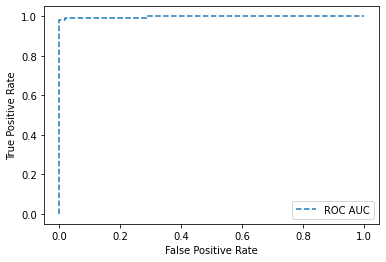

In [77]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

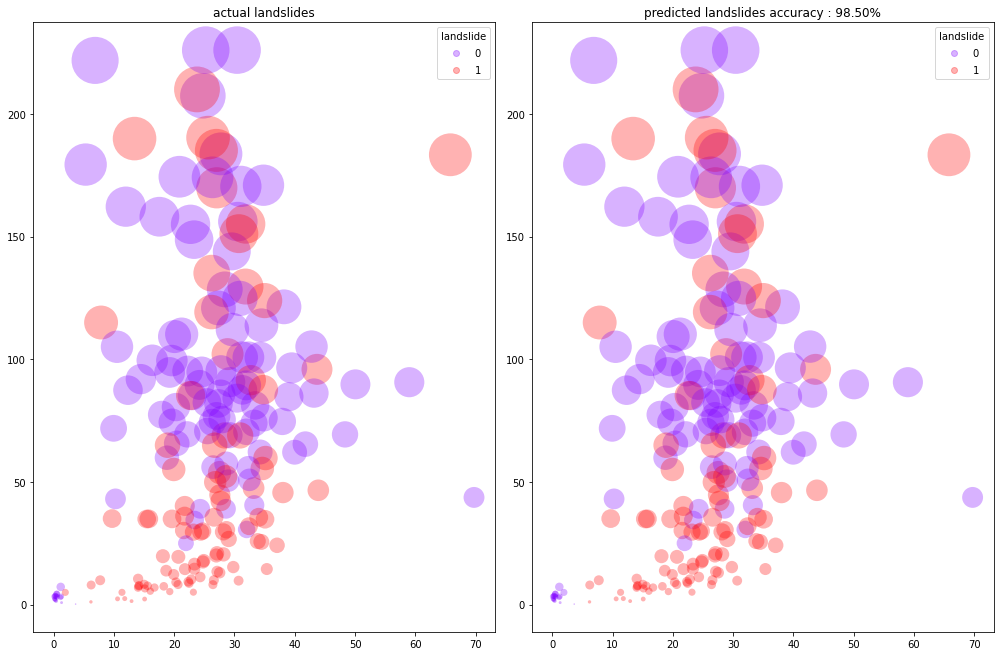

In [78]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

In [79]:
end = datetime.datetime.now()
print(end-start)

0:42:57.775681


## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- ref. 10: https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb
- ref. 11: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
- ref. 12: http://karpathy.github.io/2019/04/25/recipe/
- ref. 13: https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
- ref. 14: https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
- ref. 15: https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece
- ref. 16: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. 17: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
- ref. 18: https://machinelearningmastery.com/data-preparation-without-data-leakage/